In [61]:
import os
import sys
from pathlib import Path

import anndata as ad
import h5py
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import scanpy as sc
import seaborn as sns
from joblib import Parallel, delayed
from matplotlib.pyplot import rc_context
from skimage import exposure, io
from skimage.util import img_as_ubyte
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tqdm.notebook import tqdm, trange
from matplotlib.patches import Patch

sc.settings.verbosity = 3

In [62]:
p_dir = (Path().cwd().parents[0]).absolute()
data_dir = p_dir / "data"

In [63]:
%load_ext autoreload
%autoreload 2

module_path = str(p_dir / "src")

if module_path not in sys.path:
    sys.path.append(module_path)

# import scanorama


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
experiment = "endometrium"
cores = ["L128"]
datasets = ["L11_2", "L11_3"]+[core + f"_{i}" for core in cores for i in range(1, 4)]

# Load data

In [65]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [66]:
def read_props(dataset, experiment):
    df_morph = pd.read_csv(data_dir / "props" / f"morphology_IMC_{experiment}_{dataset}.csv")
    df_intensity_IMC = pd.read_csv(data_dir / "props" / f"intensity_IMC_{experiment}_{dataset}.csv")
    df_intensity_TS = pd.read_csv(data_dir / "props" / f"intensity_TS_{experiment}_{dataset}_auto.csv")

    return df_morph, df_intensity_IMC, df_intensity_TS

In [67]:
%%capture 

adatas = []
adatas_raw = []
df_sums = []
for dataset in datasets:
    try:
        df_morph, df_intensity_IMC, df_intensity_TS = read_props(dataset, experiment)
        print(f'Sucessfully read dataset {dataset}') 
    except:
        print(f'{dataset} cannot be read') 
        continue
    try:
        df_intensity_TS.drop(['Rest', 'Total'], axis=1, inplace=True)
    except:
        pass
    df_intensity_TS.iloc[:, 1:] = df_intensity_TS.iloc[:, 1:].multiply(
        df_morph["area"], axis=0
    )
    # data_all = df_intensity_TS.iloc[:, 1:].values
    # data_all_norm = (data_all+0.1)/(np.percentile(data_all,50,axis=1,keepdims=True)+0.1)
    # data_all_norm = MinMaxScaler().fit_transform(data_all)
    # df_intensity_TS.iloc[:, 1:] = data_all_norm
    
    # Merge TS and IMC data
    df = df_intensity_TS
    df.set_index("Id", inplace=True)
    df_sums.append(df.sum(axis=0))
    
    # Put to adata format
    adata = sc.AnnData(df.values)
    adata.var_names = df.columns.tolist()
    adata.obs["Cell"] = df.index.tolist()
    adata.obs["Dataset"] = dataset
    adata.obs["Core"] = dataset.split("_")[0]
    adata.obsm["spatial"] = df_morph[["centroid-0", "centroid-1"]].to_numpy()
    
    # FPM normalize
    sc.pp.normalize_total(adata, target_sum=1e5)
    # sc.pp.log1p(adata, base=2)
    adatas_raw.append(adata.copy())
    
    # Standard scale
    sc.pp.scale(adata)
    adatas.append(adata)
    
adata = ad.concat(adatas, join="inner")
adata_raw = ad.concat(adatas_raw, join="inner")

normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)
normalizing counts per cell
    finished (0:00:00)


In [68]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 40000)].index.tolist()

In [69]:
# Read Protein clustering info
path = data_dir / "adata" / f"{experiment}.h5ad"
adata_IMC_cluster = ad.read_h5ad(path)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [70]:
adata_IMC_cluster

AnnData object with n_obs × n_vars = 8215 × 6
    obs: 'Cell', 'Dataset', 'Core', 'leiden'
    uns: 'Core_colors', 'Dataset_colors', 'dendrogram_leiden', 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances'

In [71]:
df_sum = pd.concat(df_sums, axis=1).mean(axis=1)
mz_qc = df_sum[(df_sum > 8000)].index.tolist()

In [72]:
len(mz_qc)

174

In [73]:
adata = adata[:, mz_qc]
adata_raw = adata_raw[:, mz_qc]

## Get literature lut

In [74]:
SIMS_masses = adata.var_names

In [75]:
# Read litterature lut
file_path = data_dir / "metadata" / 'Putative_annotation_09012022.xlsx'
df = pd.read_excel(file_path)
lum = df['m/z'].to_numpy()

# get matched table by looking at difference with error
error = 0.4
matched_dfs = []
for mz in SIMS_masses.astype(float):
    if mz < 1.1:
        continue
    diff = lum-mz
    matched = df[abs(diff)<error]
    if len(matched) > 0:
        matched.loc[:,'SIMS mz'] = mz
        matched_dfs.append(matched)
    else:
        matched = pd.DataFrame([['', '', '', '', mz]], columns=df.columns.tolist() + ['SIMS mz'])
        matched_dfs.append(matched)
matched = pd.concat(matched_dfs)

C:\Users\thu71\AppData\Local\Temp\ipykernel_34028\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_34028\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matched.loc[:,'SIMS mz'] = mz
C:\Users\thu71\AppData\Local\Temp\ipykernel_34028\1921335408.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the

In [76]:
# Get all info from litterature excel
SIMS_masses_subset = np.array(matched['SIMS mz'].to_list(), dtype=float).astype(str)
SIMS_masses_subset = pd.Index(SIMS_masses_subset)

matched.loc[matched['Molecules'] != '', 'Molecules'] = ' ' + matched.loc[matched['Molecules'] != '', 'Molecules']
SIMS_name_subset = np.array(matched['Molecules'].to_list()).astype(str)
SIMS_name_subset = pd.Index(SIMS_name_subset)
SIMS_name_subset = SIMS_name_subset

SIMS_nm_subset = SIMS_masses_subset + 'm/z' + SIMS_name_subset 

SIMS_type_subset = np.array(matched['Type'].to_list()).astype(str)
SIMS_type_subset = pd.Index(SIMS_type_subset)

print(f"Number of matched m/z: {len(SIMS_masses_subset)}")

Number of matched m/z: 174


In [77]:
adata_all = adata.copy()
adata = adata[:, SIMS_masses_subset]
adata.var_names = SIMS_nm_subset

C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [78]:
adata_raw = adata_raw[:, SIMS_masses_subset]
adata_raw.var_names = SIMS_nm_subset


# Rename clusters

In [79]:
import palettable
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap


In [80]:
type_dict = {'1': 'Other',
            '0': 'Epithelial',
            '2': 'Vimentin+', 
            '3': 'CD3+CD8+',
            }

In [81]:
adata_CN = adata_IMC_cluster.copy()

In [82]:
adata_CN.obs['Type'] = (
    adata_CN.obs['leiden']
    .map(type_dict)
    .astype("category")
)
adata_CN.uns['Type_colors'] = adata_CN.uns['leiden_colors'][:len(np.unique(adata_CN.obs['Type']))]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Type']`


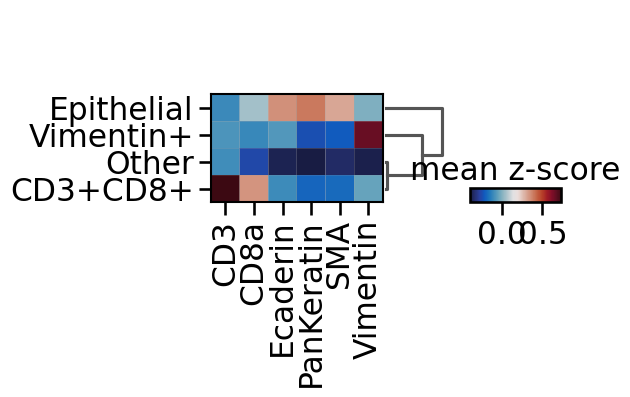

In [83]:
sc.tl.dendrogram(adata_CN, groupby='Type')

sc.pl.matrixplot(
    adata_CN,
    adata_CN.var_names.tolist(),
    "Type",
    dendrogram=True,
    colorbar_title="mean z-score",
    cmap=heatmap_cmp,
    swap_axes=False,
    # vmin=-0.25,
    # vmax=0.5
)

In [84]:
cluster_label_order = adata_CN.uns['dendrogram_Type']['categories_ordered']

In [85]:
import matplotlib 

colors = adata_CN.uns["Type_colors"]
labels = adata_CN.obs.Type.cat.categories.tolist()

colors_rgb = []
for color in colors:
    colors_rgb.append(matplotlib.colors.hex2color(color))
colors_rgb = np.array(colors_rgb) * 255
colors_rgb = colors_rgb.astype(np.uint8)

colors_rgb_dict = {k:v for k,v in zip(labels, colors_rgb)}

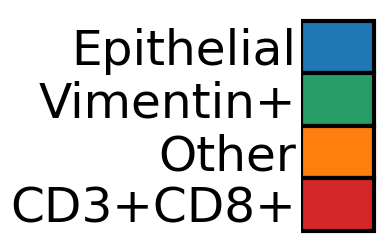

In [86]:
c=np.array([colors_rgb_dict[i] for i in cluster_label_order])

# legend
fig, ax = plt.subplots(figsize=(1,3))
ax.barh(y=range(len(colors_rgb_dict.values())), 
        color=c/255,
        width=1, 
        height=1,
        edgecolor='k',
        linewidth=3,
       )
_ = plt.yticks(range(len(colors_rgb_dict.values())), cluster_label_order, rotation=0, size=35)
_ = plt.xticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.tick_params(axis=u'both', which=u'both',length=0)
# ax.yaxis.tick_right()
ax.invert_yaxis()
ax.grid(False)


# Comparison metabolites

In [87]:
adata.obs["Region"] = adata_CN.obs["Type"]
adata.uns["Region_colors"] = adata_CN.uns["Type_colors"]

adata.obsm["spatial"] = adata_CN.obsm["spatial"]

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Region']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
C:\Users\thu71\Anaconda3\envs\scanpy\Lib\site-packages\scanpy\tools\_rank_genes_groups.py:420: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


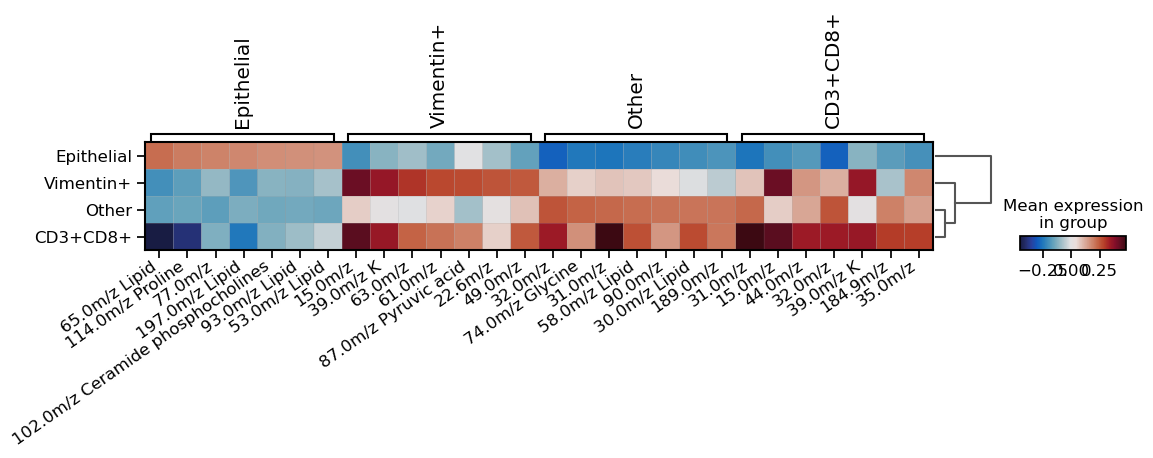

In [88]:
sc.tl.dendrogram(adata, groupby='Region')
sc.tl.rank_genes_groups(adata, groupby='Region', method='t-test_overestim_var', use_raw=False)

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [89]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)

# Get top diff expression
topk=10
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

In [90]:
# Extract dataframe
var = 'Region'

adata_subset = adata[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Region']`


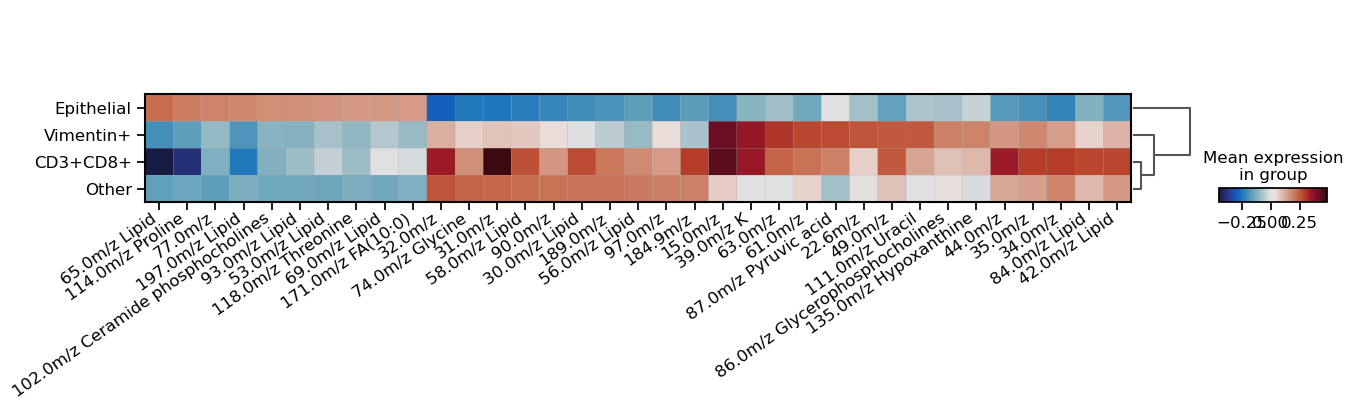

In [91]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [92]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata, group=None)
dedf = dedf[dedf.group != 'Other']

# Get top diff expression
topk=6
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
# masses = np.unique(np.concatenate([masses_largest, masses_lowest]))
masses = masses_largest

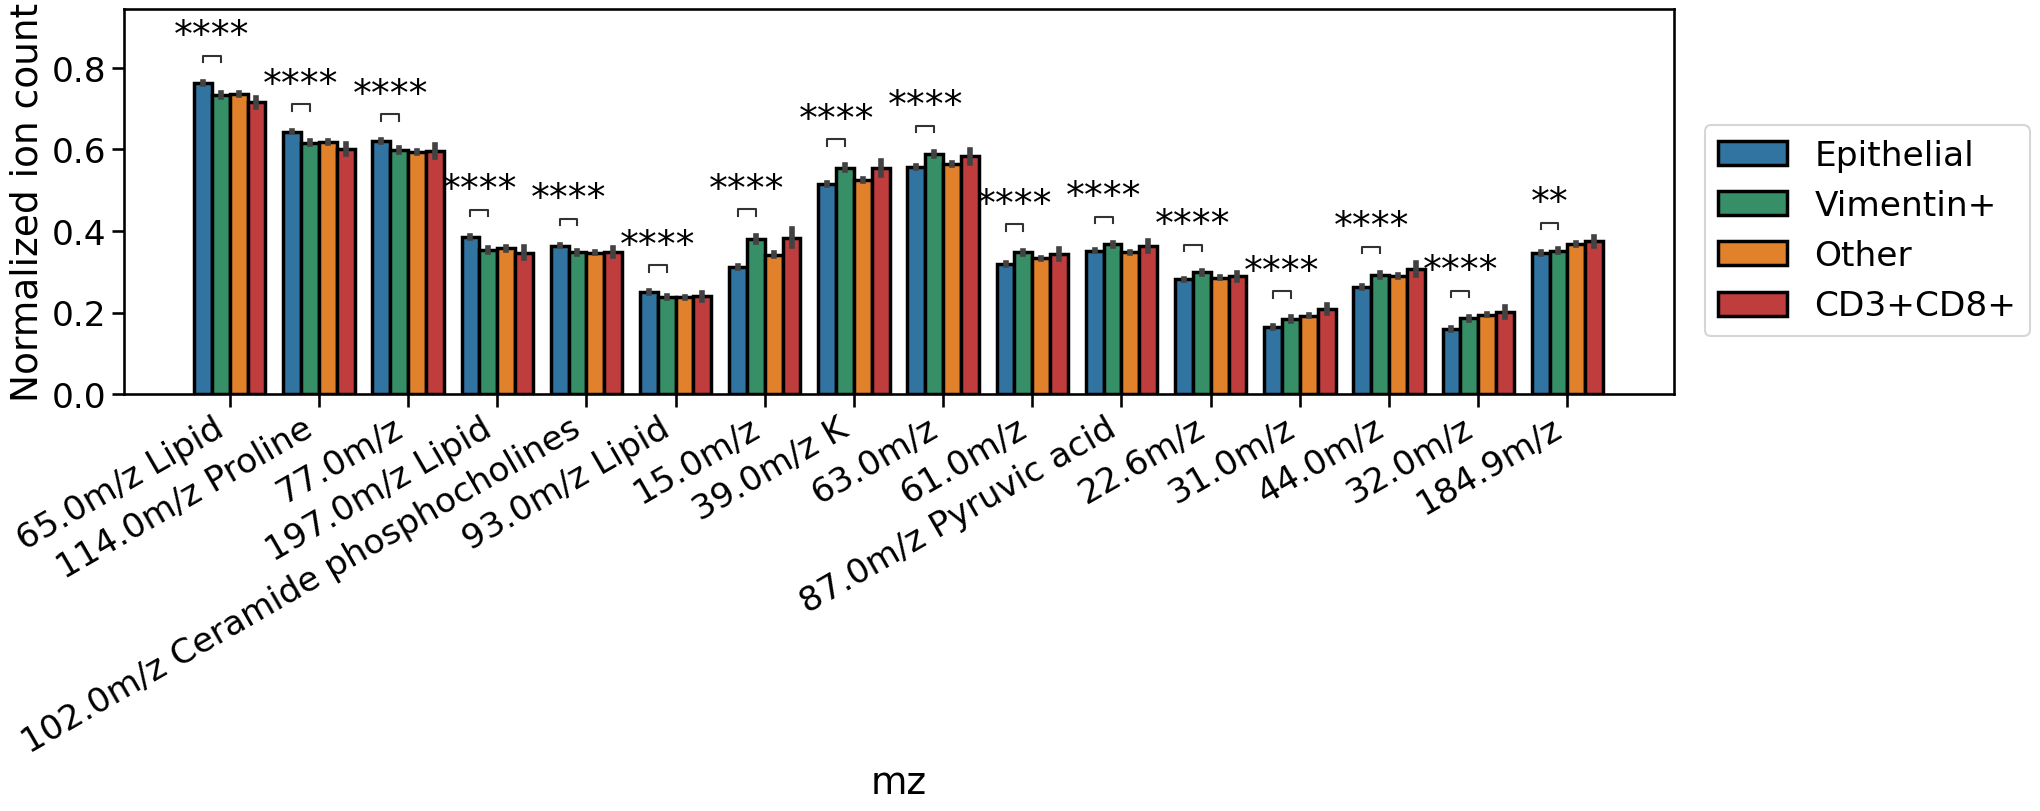

In [93]:
sns.set_context('talk', font_scale=1.5)
from statannotations.Annotator import Annotator

# Get subset of masses
adata_subset = adata[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Epithelial'),(e,'Vimentin+')) for e in masses]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()
# ax.set(ylim=(.2, 1.))

In [94]:
masses

array(['65.0m/z Lipid', '114.0m/z Proline', '77.0m/z', '197.0m/z Lipid',
       '102.0m/z Ceramide phosphocholines', '93.0m/z Lipid', '15.0m/z',
       '39.0m/z K', '63.0m/z', '61.0m/z', '87.0m/z Pyruvic acid',
       '22.6m/z', '31.0m/z', '44.0m/z', '32.0m/z', '184.9m/z'],
      dtype=object)

### Manual selection

In [95]:
glucose_frag = ['71.0m/z', '87.0m/z Pyruvic acid', '99.0m/z Lipid', '119.0m/z', '141.0m/z Lipid', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]
# glucose_frag = ['87.0m/z Pyruvic acid', '99.0m/z L-Frag', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]

amino_acids = ['74.0m/z Glycine',  '88.0m/z Alanine', '104.0m/z Serine', '114.0m/z Proline', 
               '116.0m/z Valine', '118.0m/z Threonine', '120.0m/z Cysteine', 
               '130.0m/z Isoleucine/leucine', '131.0m/z Asparagine', '132.0m/z Aspartic acid', 
               '145.0m/z Glutamine', '146.0m/z Glutamic acid']

cholesterol_frag = ['95.0m/z Cholesterol fragment', 
                    '109.0m/z Cholesterol fragment', 
                    '147.0m/z Cholesterol fragment',
                    '161.0m/z Cholesterol fragment']

lipids = [e for e in SIMS_nm_subset if 'Lipid' in e]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Region']`


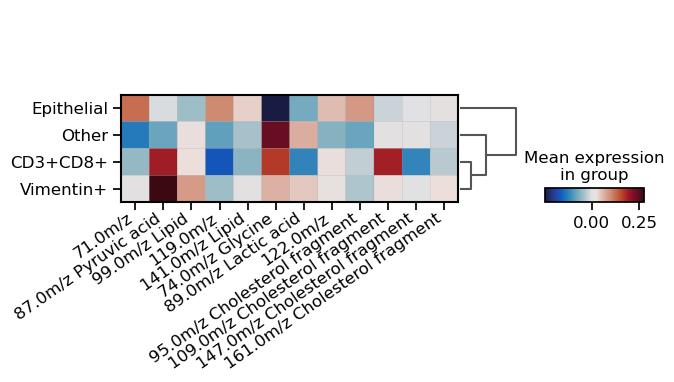

In [96]:
# Plot glucose
adata_subset = adata[:,glucose_frag+cholesterol_frag]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp, 
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

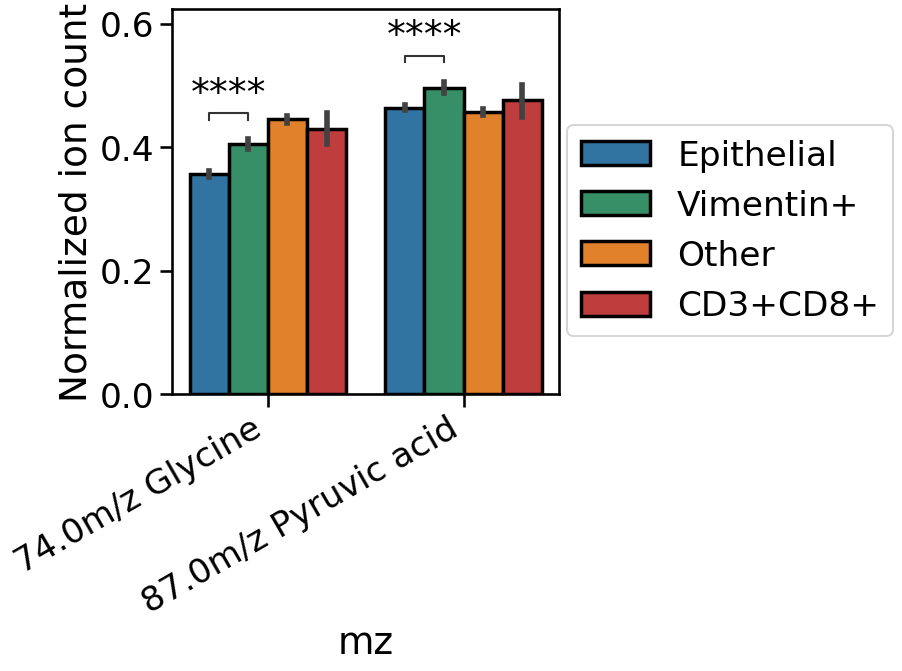

In [97]:
# Get subset of masses
masses_subset = ['74.0m/z Glycine', '87.0m/z Pyruvic acid']
adata_subset = adata[adata.obs.Core == 'L128',masses_subset]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(5,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Epithelial'),(e,'Vimentin+')) for e in masses_subset]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()

In [98]:
df_SIMS_var.to_clipboard()

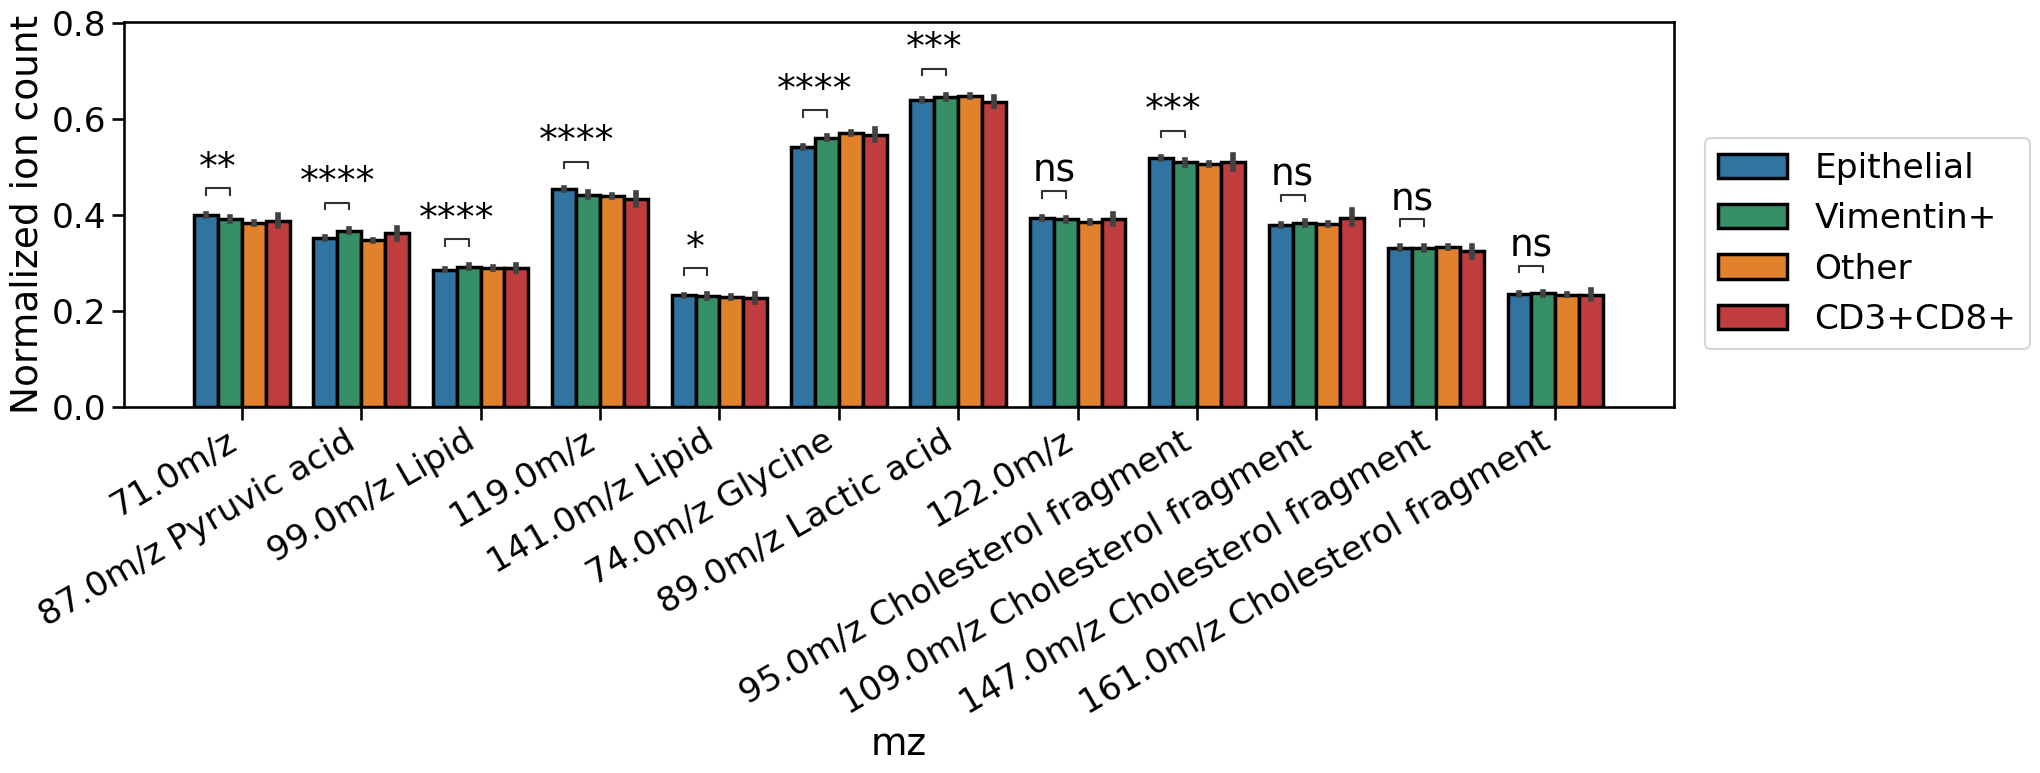

In [99]:
# Get subset of masses
adata_subset = adata[:,glucose_frag+cholesterol_frag]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Epithelial'),(e,'Vimentin+')) for e in glucose_frag+cholesterol_frag]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Region']`


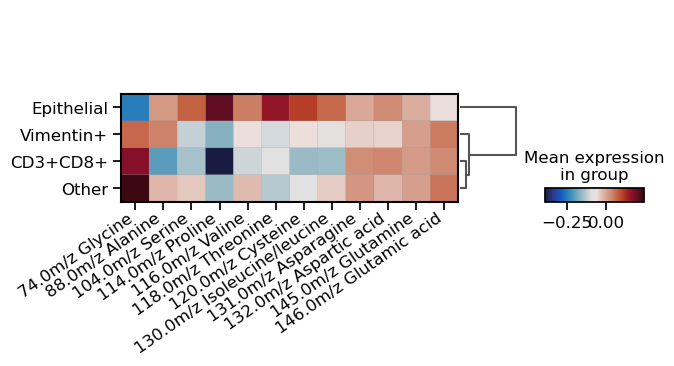

In [100]:
# Plot glucose
adata_subset = adata[:,amino_acids]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

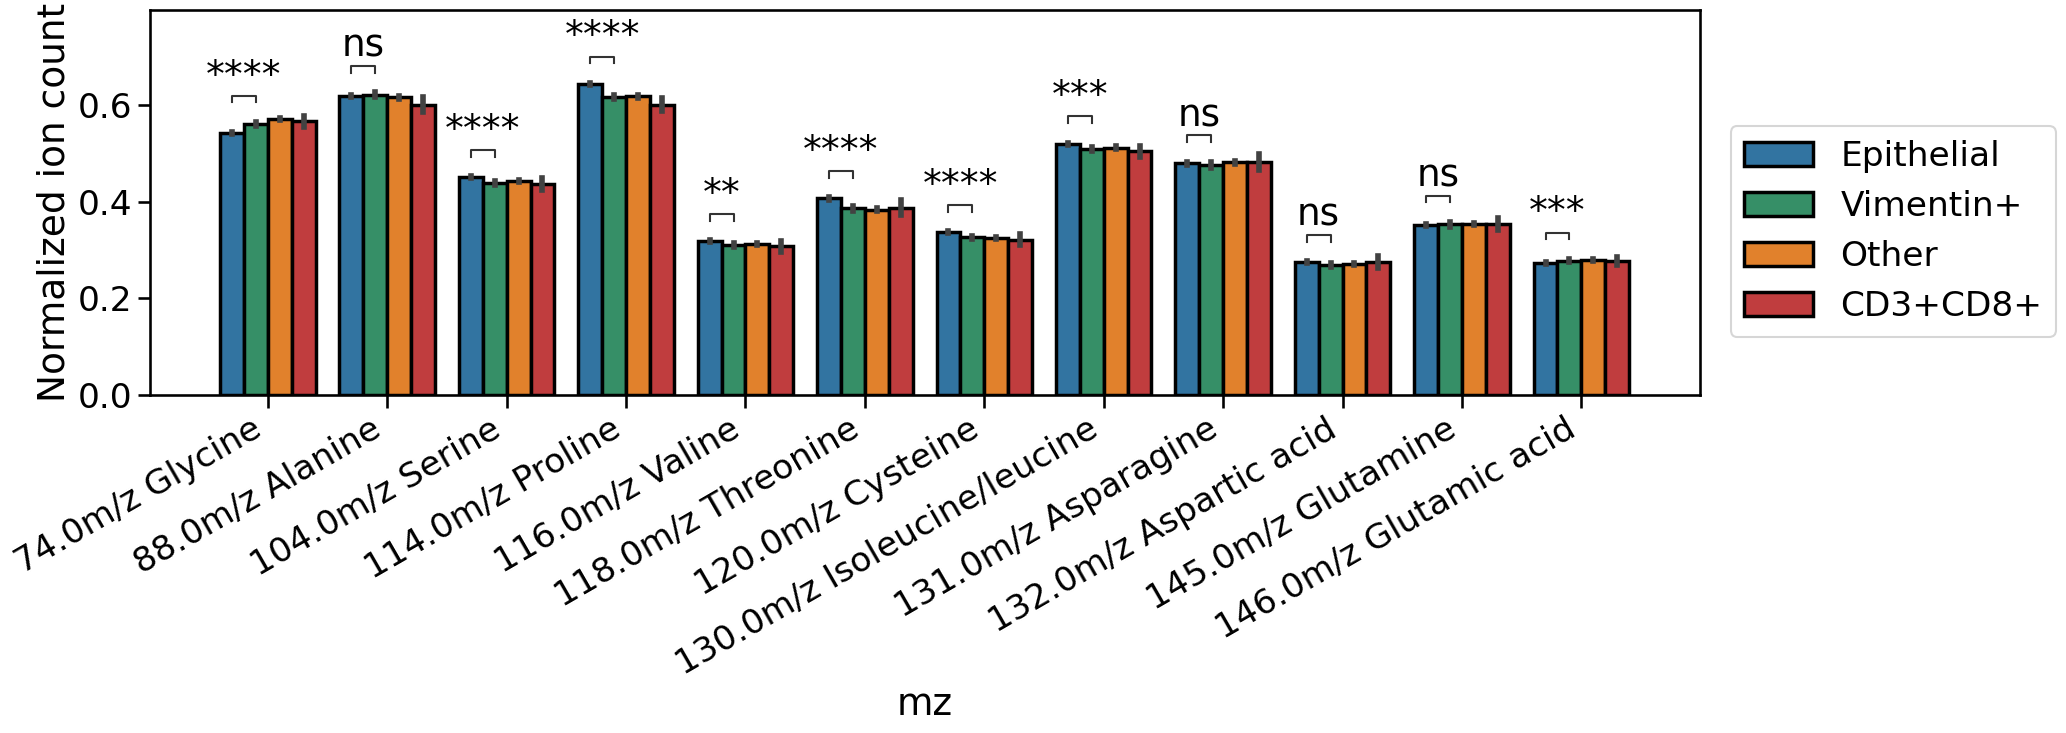

In [101]:
# Get subset of masses
adata_subset = adata[:,amino_acids]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
var = 'Region'
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Epithelial'),(e,'Vimentin+')) for e in amino_acids]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Region']`


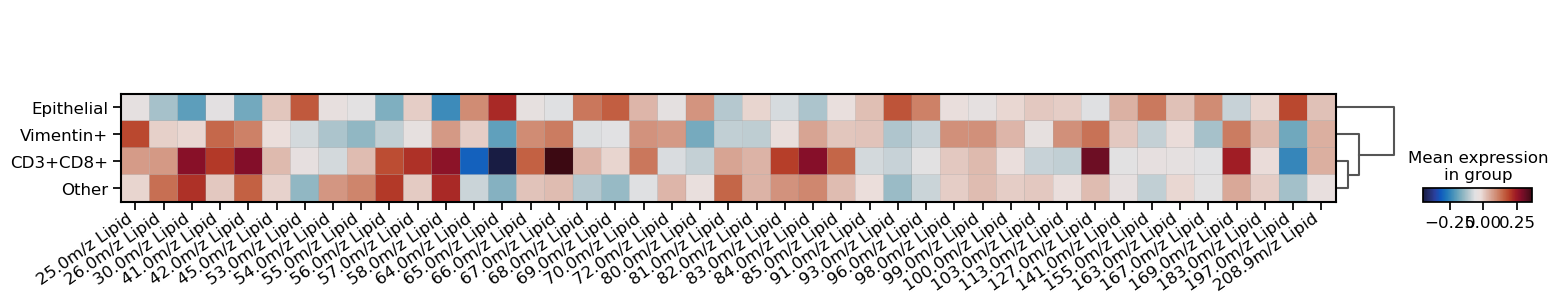

In [102]:
# Plot glucose
adata_subset = adata[:,lipids]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

### Plot by mz channel

In [103]:
import palettable
h5_data_dir = p_dir / "data" / "h5"
heatmap_cmp = palettable.cmocean.diverging.Balance_20.mpl_colormap

from typing import List
import matplotlib
import skimage
from skimage import measure

h5_data_dir = p_dir / "data" / "h5"

# Read mask image
def get_masks(mask_folder):
    """
    Function to get all mask from mask forlder
    """
    # Read masks
    masks = {}

    for (dirpath, dirnames, filenames) in os.walk(mask_folder):
        for name in sorted(filenames):
            if "tif" in name:
                filename = os.path.join(dirpath, name)
                img = skimage.io.imread(filename)
                condition = name.split(".")[0]
                masks[condition] = img
            else:
                continue
    return masks


def create_clustered_cell(mask, cell2count,  **kwargs):
    img = np.zeros((mask.shape[0], mask.shape[1]))*np.nan

    for cell, counts in cell2count.items():
        rows, cols = np.where(np.isin(mask, cell))
        img[rows, cols] = counts

    return img

def get_contour(mask: np.ndarray) -> List[List[float]]:
    """
    Get contours of mask
    """
    contours = []
    for i in sorted(np.unique(mask)):
        if i == 0:
            continue
        contours.append(measure.find_contours(mask == i, 0.8)[0])

    return contours

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    fig, ax = plt.subplots(figsize=(10,10))
    ax.imshow(mz_img, cmap='rainbow', interpolation='quadric', vmin=0, vmax=np.percentile(mz_img, 90))  
    ax.axis('off')
    plt.title(f'{mz} m/z')
    plt.show()
    return mz_img 

def get_imgs_sims(experiment, name):
    with h5py.File(h5_data_dir / f"{experiment}.hdf5", "r") as f:
        imgs = f[name][:]
        labels = list(f[name].attrs["labels"])
    return imgs[2:], labels[2:]

def IMS(imgs, mz, masses):
    mz_img = imgs[np.equal(masses, mz),...][0]
    # fig, ax = plt.subplots(figsize=(7,7))
    # ax.imshow(mz_img, cmap=heatmap_cmp, interpolation='quadric', vmin=0,vmax=np.percentile(mz_img, 99))  
    # ax.axis('off')
    # plt.title(f'{mz} m/z')
    # plt.show()
    return mz_img 

In [104]:
masks = get_masks(data_dir / "masks")
experiment='endometrium'

In [105]:
len(masses)

16

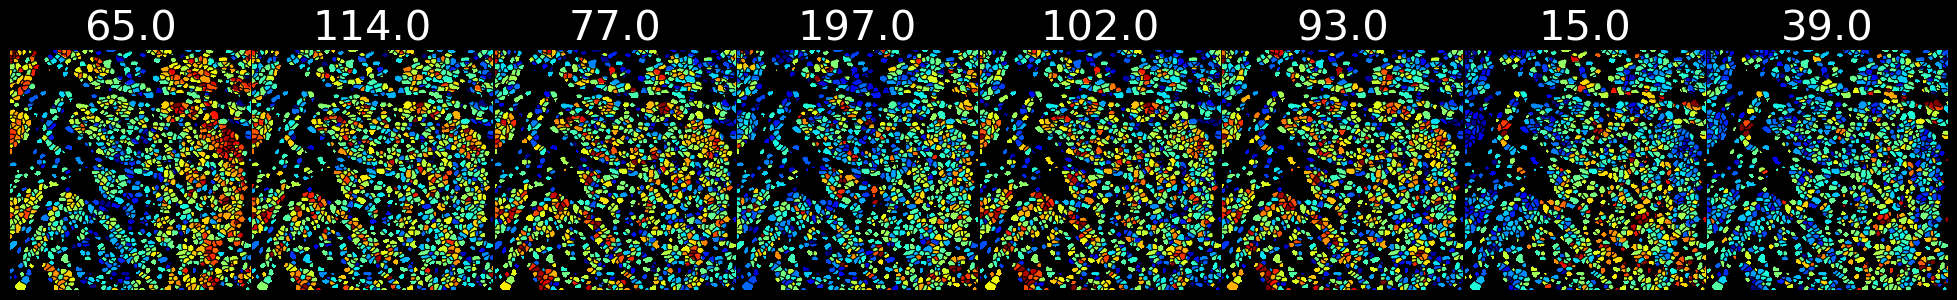

In [106]:
dataset = 'L128_2'

mask = masks[experiment + '_' + dataset]
if dataset in ['L11_2', 'L11_3']:
    mask = mask[:400,:400]
contours = get_contour(mask)

adata_fov = adata[adata.obs['Dataset'] == dataset]

fig, axs = plt.subplots(1,8,figsize=(25, 10), facecolor='k')
axs = axs.flatten()
for i, channel in enumerate(masses[:8]):
    ax = axs[i]
    
    adata_subset = adata_fov[:, channel]
    # Get label2cell dict
    cells = adata_subset.obs['Cell'].to_list()
    counts = adata_subset.X.flatten()
    cell2count = dict(zip(cells, counts))

    img = create_clustered_cell(mask, cell2count)

    ax.set_title(f"{channel.split('m/z')[0]}", size=30, c='w')
    ax.imshow(img, cmap='jet', vmin=np.nanpercentile(img, 1), vmax=np.nanpercentile(img, 99))
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")
    ax.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()

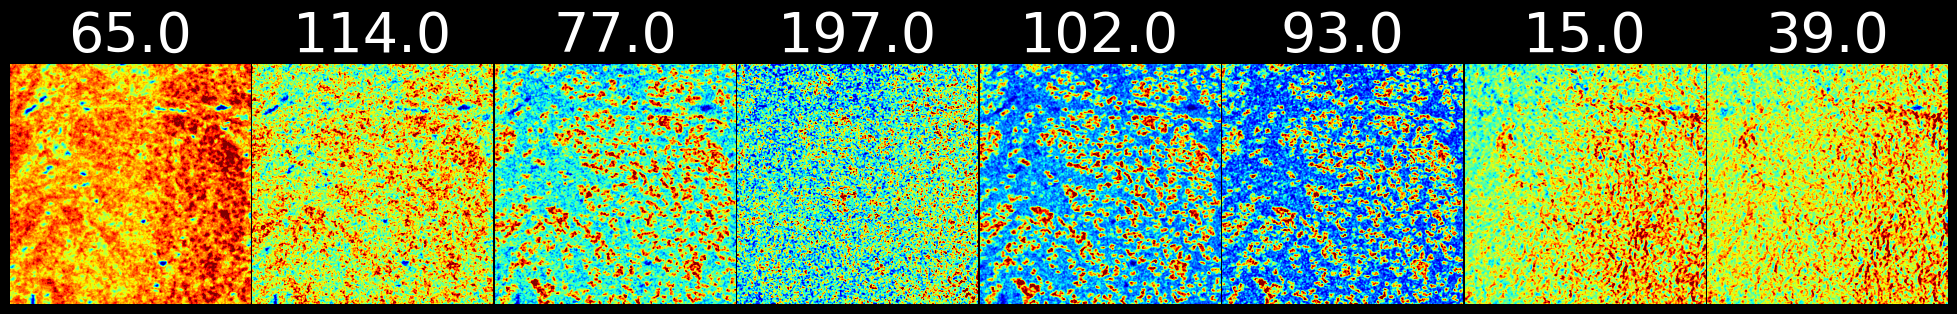

In [107]:
imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
mzs = np.array(df_intensity_TS.columns.tolist()).astype(float)
imgs_stack = skimage.transform.resize(imgs, (imgs.shape[0], mask.shape[0], mask.shape[0]), order=2, preserve_range=True, anti_aliasing=False)
mean = np.mean(imgs_stack, axis=0, keepdims=False)+1

fig, axs = plt.subplots(1,8,figsize=(25, 10), facecolor='k')
axs = axs.flatten()
for i, channel in enumerate(masses[:8]):
    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, anti_aliasing=True, anti_aliasing_sigma=1)
    mz_img = mz_img / mean
    if dataset in ['L11_2', 'L11_3']:
        mz_img = mz_img[:400,:400]
    ax.imshow(mz_img, cmap='jet', interpolation=None, vmin=np.percentile(mz_img, 0), vmax=np.percentile(mz_img, 98))
    ax.set_title(mz, size=40, c='w')
    ax.axis("off")
fig.subplots_adjust(wspace=0.01, hspace=0.15)
plt.show()


### Plot one mz for couple of ROI

In [108]:
datasets_subset = datasets

In [109]:
masses

array(['65.0m/z Lipid', '114.0m/z Proline', '77.0m/z', '197.0m/z Lipid',
       '102.0m/z Ceramide phosphocholines', '93.0m/z Lipid', '15.0m/z',
       '39.0m/z K', '63.0m/z', '61.0m/z', '87.0m/z Pyruvic acid',
       '22.6m/z', '31.0m/z', '44.0m/z', '32.0m/z', '184.9m/z'],
      dtype=object)

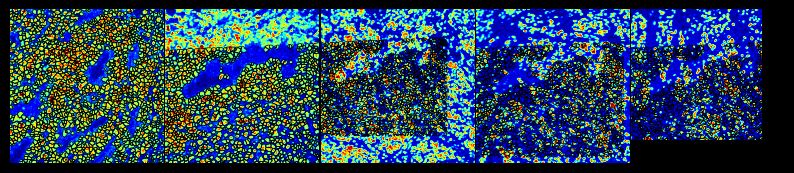

In [110]:
fig, axs = plt.subplots(1,5,figsize=(10,3), facecolor='k')
axs = axs.flatten()
channel = '53.0m/z Lipid'

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]


    imgs, labels = get_imgs_sims(experiment, 'auto_'+dataset)
    mzs = np.array(df_intensity_TS.columns.tolist()).astype(float)

    ax = axs[i]
    ax.axis("off")
    mz = float(channel.split('m/z')[0])
    mz_img = IMS(imgs, mz, mzs)
    mz_img = skimage.transform.resize(mz_img, mask.shape, anti_aliasing=True, anti_aliasing_sigma=1)
    
    if dataset in ['L11_2', 'L11_3']:
        mask = mask[:400,:400]
        contours = get_contour(mask)
        mz_img = mz_img[:400,:400]
    
    ax.imshow(mz_img, cmap='jet', interpolation=None, vmin=np.percentile(mz_img, 0.5), vmax=np.percentile(mz_img, 99.5))
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")
    ax.axis("off")

fig.subplots_adjust(wspace=0.01)

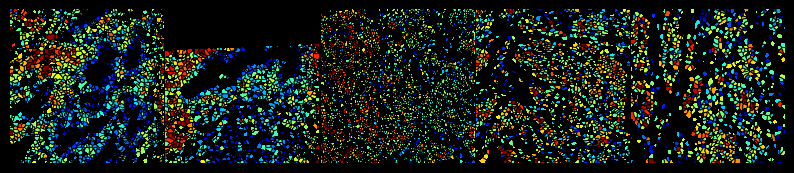

In [111]:
fig, axs = plt.subplots(1,5,figsize=(10,3), facecolor='k')
axs = axs.flatten()

for i, dataset in enumerate(datasets_subset):
    mask = masks[experiment + '_' + dataset]
    if dataset in ['L11_2', 'L11_3']:
        mask = mask[:400,:400]
        
    contours = get_contour(mask)
    adata_subset = adata[adata.obs['Dataset'] == dataset, channel]
    
    # Get label2cell dict
    cells = adata_subset.obs['Cell'].to_list()
    counts = adata_subset.X.flatten()
    cell2count = dict(zip(cells, counts))

    img = create_clustered_cell(mask, cell2count)
    
    ax = axs[i]
    ax.axis("off")

    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_facecolor('darkblue')
    if dataset in ['L11_2', 'L11_3']:
        img = img[:400,:400]
    
    ax.imshow(img, cmap='jet', vmin=np.nanpercentile(img, 2), vmax=np.nanpercentile(img, 98))
    for j, contour in enumerate(contours):
        ax.plot(contour[:, 1], contour[:, 0], linewidth=0.5, color="k")

fig.subplots_adjust(wspace=0.01)

# Comparison metabolites distribution across patient

In [112]:
adata_raw.obs['Condition'] = adata_raw.obs.Core.map({'L11': 'Obese', 'L128': 'Lean'})
adata_raw.obs['Condition'] = adata_raw.obs['Condition'].astype('category')

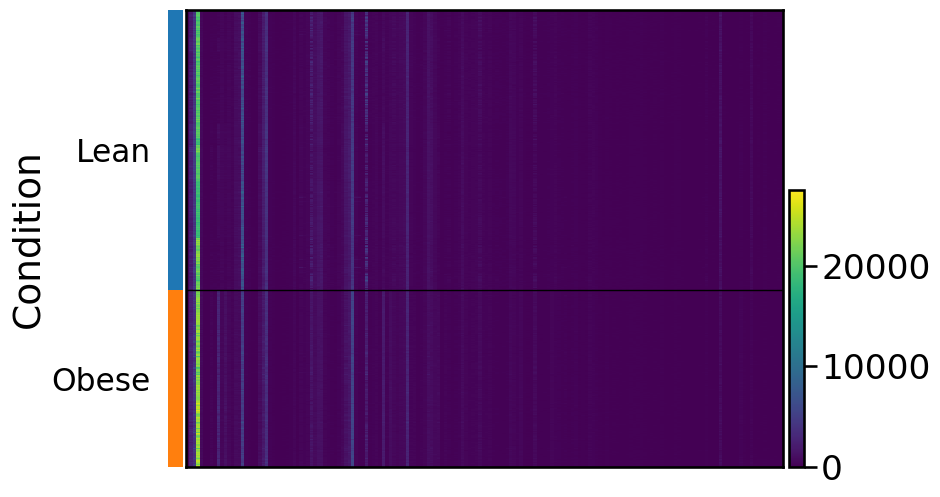

In [113]:
sc.pl.heatmap(adata_raw, adata_raw.var_names, groupby='Condition')

In [114]:
data_all = adata_raw.X
data_all_norm = (data_all+1)/(np.percentile(data_all,50,axis=1,keepdims=True)+1)
data_all_norm = MinMaxScaler().fit_transform(data_all_norm)
adata_raw.X = data_all_norm

         Falling back to preprocessing with `sc.pp.pca` and default params.
computing PCA
    with n_comps=50
    finished (0:00:00)
Storing dendrogram info using `.uns['dendrogram_Condition']`
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


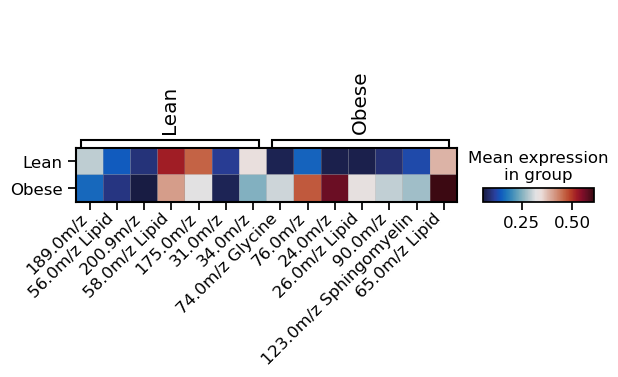

In [115]:
sc.tl.dendrogram(adata_raw, groupby='Condition')
sc.tl.rank_genes_groups(adata_raw, groupby='Condition', method='t-test')

with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.rank_genes_groups_matrixplot(adata_raw, n_genes=7, use_raw=False, cmap=heatmap_cmp, show=False,)
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 45, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [116]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_raw, group=None)

# Get top diff expression
topk=20
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

In [117]:
# Extract dataframe
var = 'Condition'

adata_subset = adata_raw[:,masses]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()

df_SIMS_grouped = df_SIMS.groupby([var]).mean()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


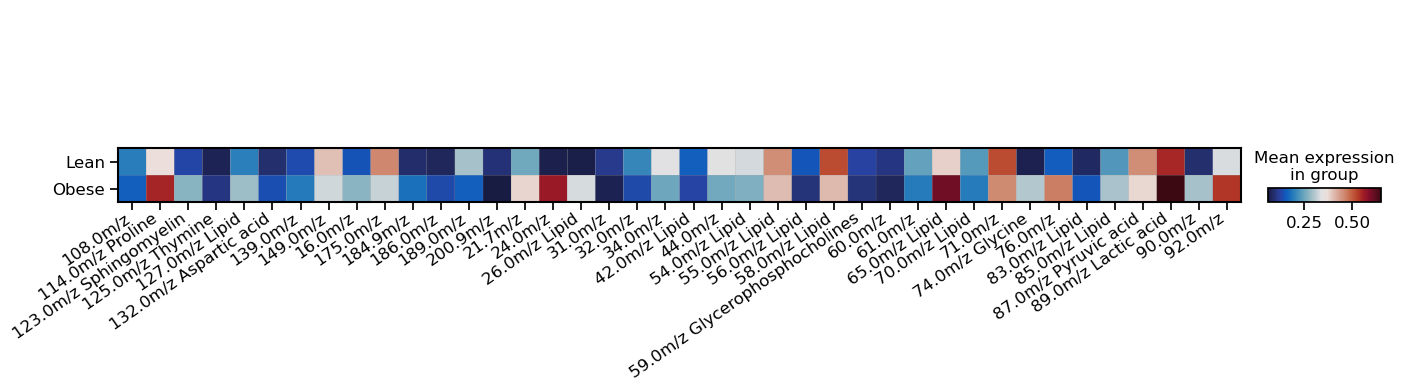

In [118]:
adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

In [119]:
# Extract diff expression dataframe
dedf = sc.get.rank_genes_groups_df(adata_raw, group=None)

# Get top diff expression
topk=15
masses_largest = dedf.groupby('group').apply(lambda x: x.nlargest(topk,['scores'])).names.unique()
masses_lowest = dedf.groupby('group').apply(lambda x: x.nsmallest(topk,['scores'])).names.unique()
masses = np.unique(np.concatenate([masses_largest, masses_lowest]))

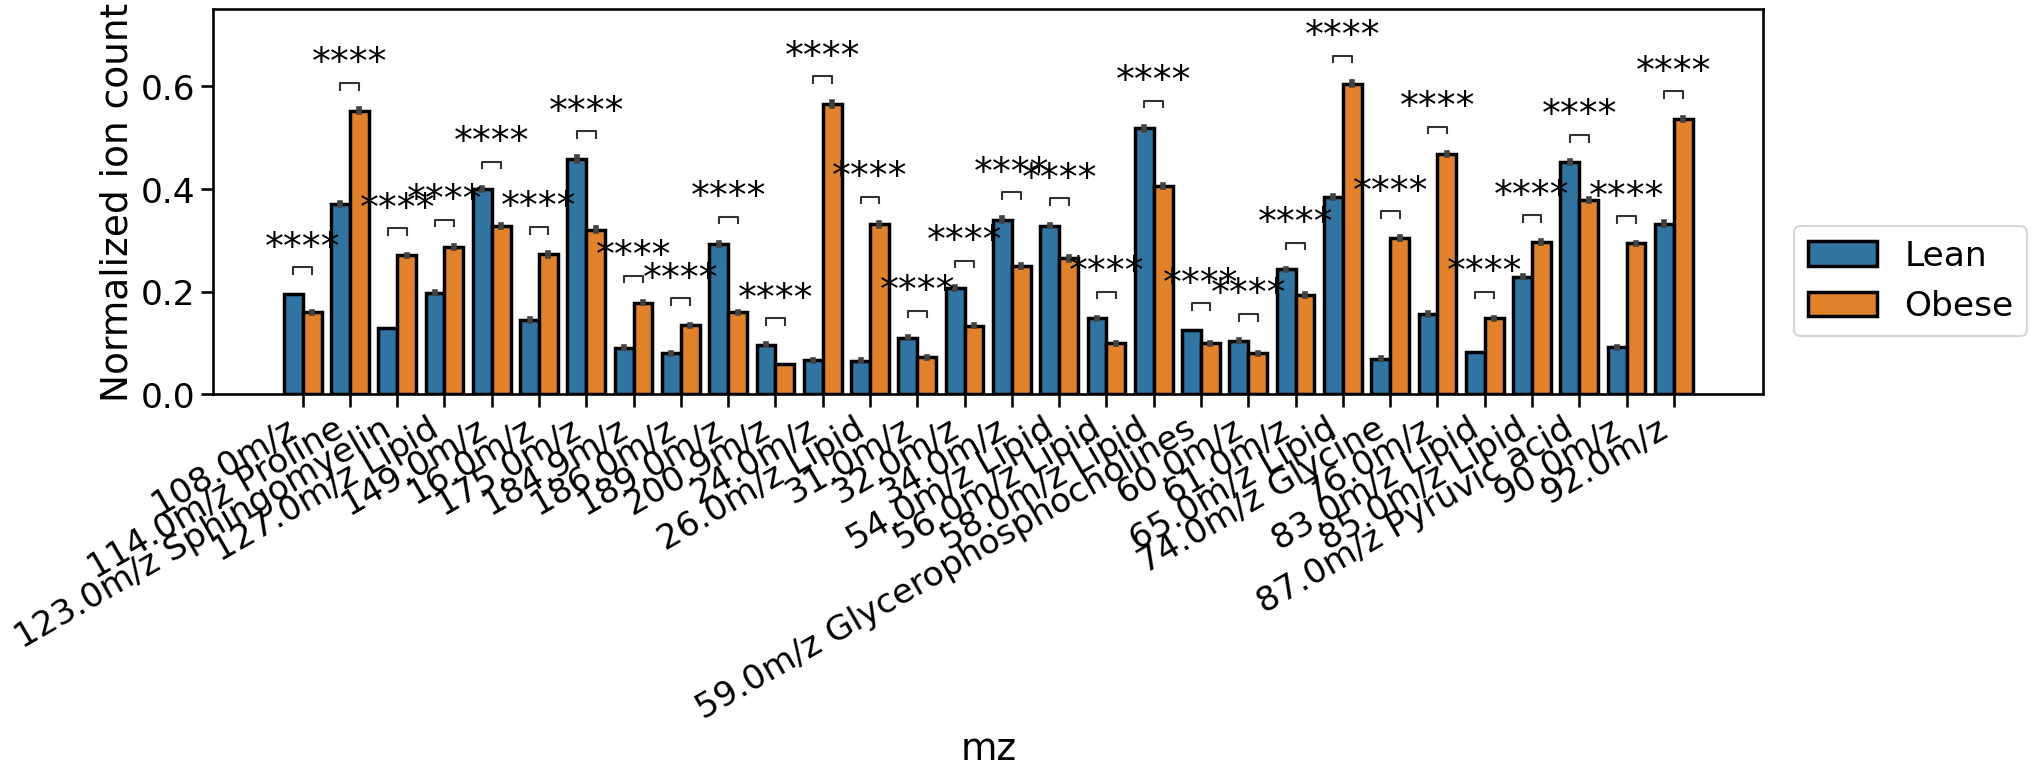

In [120]:
sns.set_context('talk', font_scale=1.5)
from statannotations.Annotator import Annotator

# Get subset of masses
adata_subset = adata_raw[:,masses]

# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Lean'),(e,'Obese')) for e in masses]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()
# ax.set(ylim=(.2, 1.))

### Manual selection

In [121]:
glucose_frag = ['71.0m/z', '87.0m/z Pyruvic acid', '99.0m/z Lipid', '119.0m/z', '141.0m/z Lipid', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]
# glucose_frag = ['87.0m/z Pyruvic acid', '99.0m/z L-Frag', '74.0m/z Glycine',  '89.0m/z Lactic acid', '122.0m/z', ]

amino_acids = ['74.0m/z Glycine',  '88.0m/z Alanine', '104.0m/z Serine', '114.0m/z Proline', 
               '116.0m/z Valine', '118.0m/z Threonine', '120.0m/z Cysteine', 
               '130.0m/z Isoleucine/leucine', '131.0m/z Asparagine', '132.0m/z Aspartic acid', 
               '145.0m/z Glutamine', '146.0m/z Glutamic acid']

cholesterol_frag = ['95.0m/z Cholesterol fragment', 
                    '109.0m/z Cholesterol fragment', 
                    '147.0m/z Cholesterol fragment',
                    '161.0m/z Cholesterol fragment']

lipids = [e for e in SIMS_nm_subset if 'Lipid' in e]

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


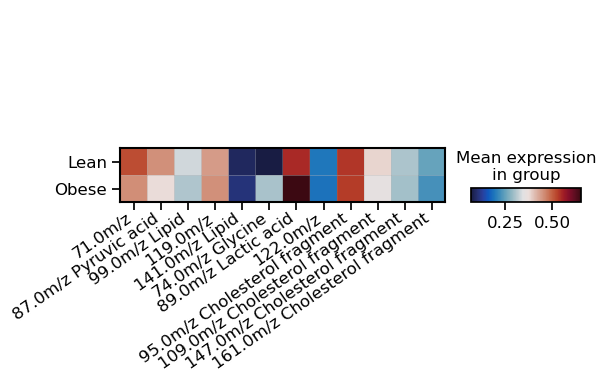

In [122]:
# Plot glucose
adata_subset = adata_raw[:,glucose_frag+cholesterol_frag]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp, 
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

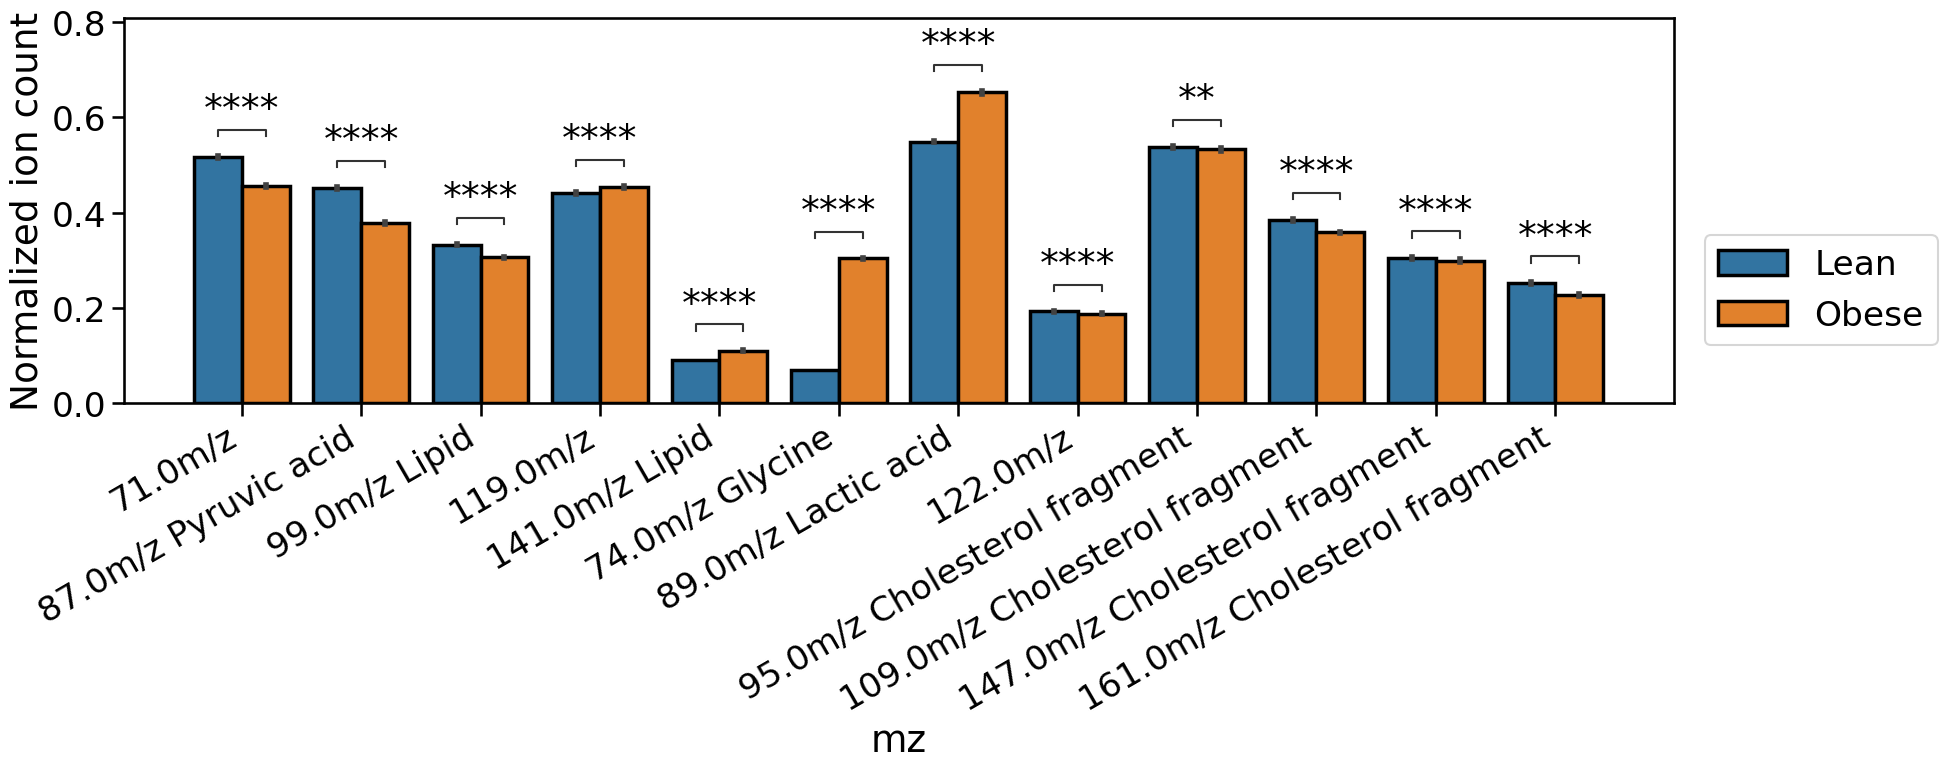

In [123]:
# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Lean'),(e,'Obese')) for e in glucose_frag+cholesterol_frag]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


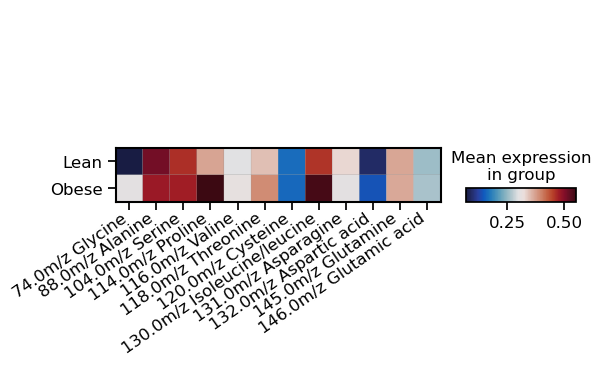

In [124]:
# Plot glucose
adata_subset = adata_raw[:,amino_acids]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()

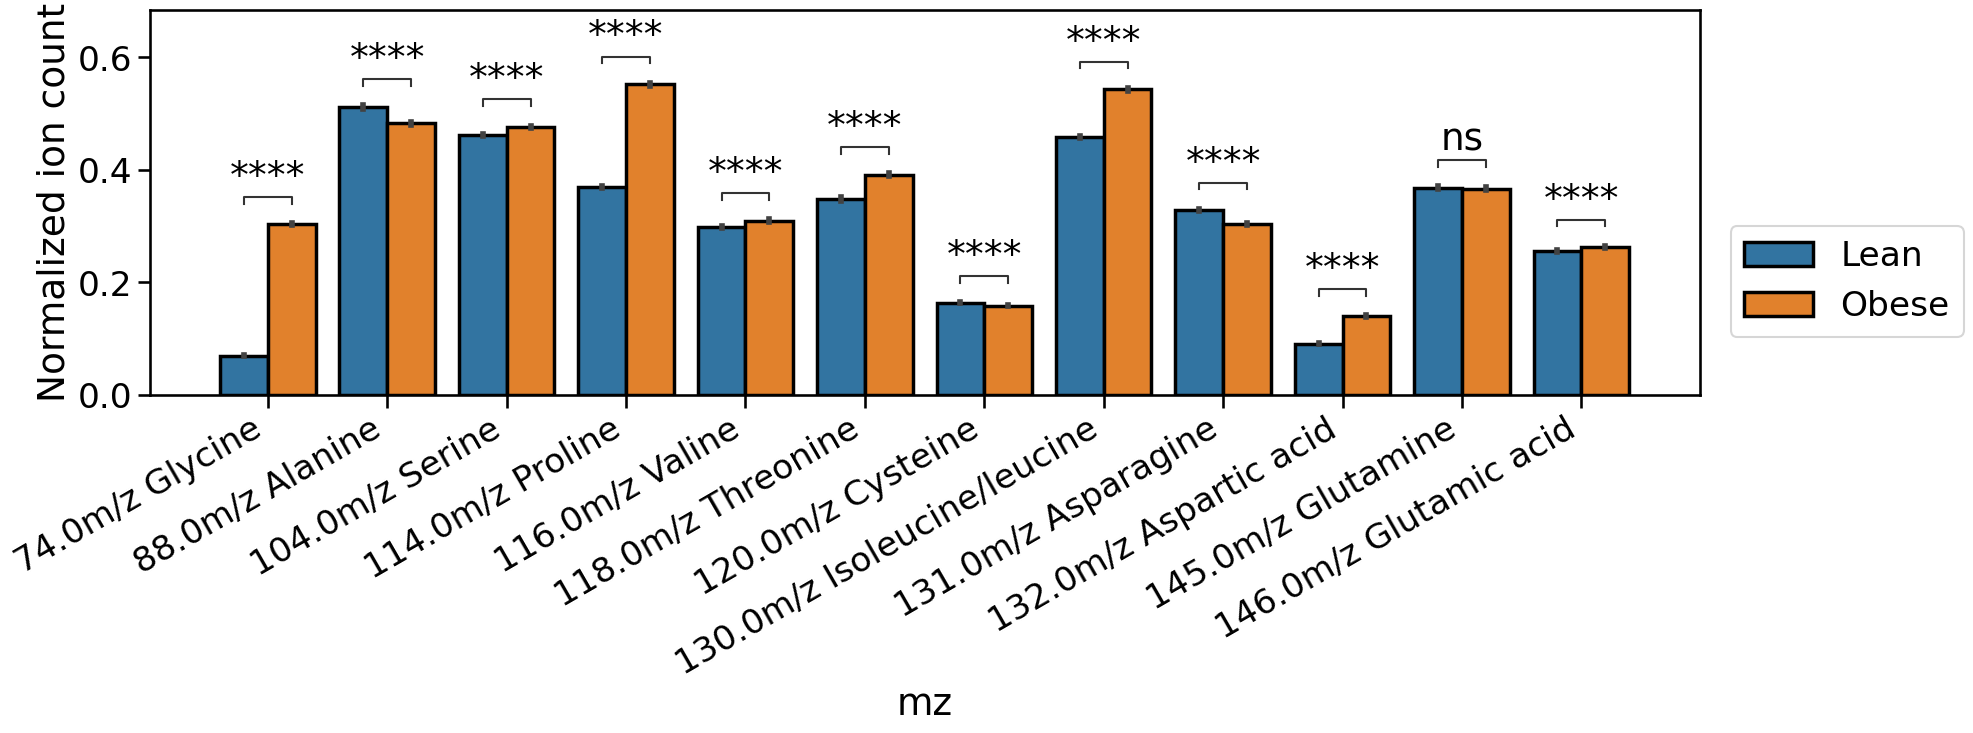

In [140]:
# Get dataframe
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS.iloc[:,:-1] = MinMaxScaler().fit_transform(df_SIMS.iloc[:,:-1].values)

# Sort masses by GC eexpression
df_SIMS_var = (df_SIMS
                .melt(id_vars=var, var_name='mz', value_name='Normalized ion count'))

# Plot
hue_order = adata_subset.uns[f'dendrogram_{var}']['categories_ordered']
palette = adata_subset.uns[f'{var}_colors'][adata_subset.uns[f'dendrogram_{var}']['categories_idx_ordered']]

fig, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', linewidth=2.5, edgecolor='k',
            hue_order = hue_order, ax=ax, palette=palette)
plt.xticks(rotation = 30, ha='right')
plt.legend(bbox_to_anchor=(1.02, 0.15), loc='lower left', borderaxespad=0)

pairs = [((e,'Lean'),(e,'Obese')) for e in amino_acids]
annot = Annotator(ax, pairs, data=df_SIMS_var, hue=var, x='mz', y='Normalized ion count', hue_order = hue_order)
annot.configure(test='Mann-Whitney', text_format='star', loc='inside', verbose=0)
annot.apply_test()
ax, test_results = annot.annotate()

In [141]:
df_SIMS_var.to_clipboard()

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_Condition']`


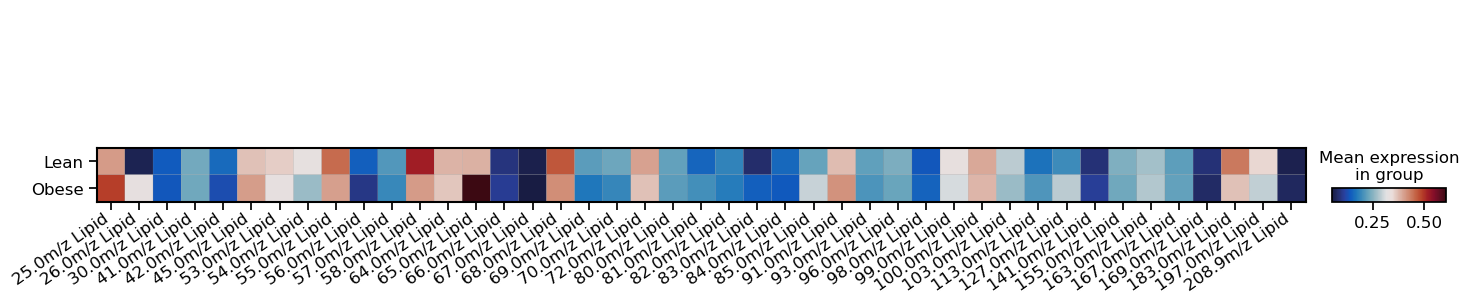

In [126]:
# Plot glucose
adata_subset = adata_raw[:,lipids]
df_SIMS = pd.DataFrame(adata_subset.X, columns=adata_subset.var_names)
df_SIMS[var] = adata_subset.obs[var].tolist()
df_SIMS_grouped = df_SIMS.groupby([var]).mean()

adata_grouped = ad.AnnData(df_SIMS_grouped.values)
adata_grouped.var_names = df_SIMS_grouped.columns.tolist()
adata_grouped.obs[var] = df_SIMS_grouped.index.tolist()
adata_grouped.obs[var] = adata_grouped.obs[var].astype('category')

sc.tl.dendrogram(adata_grouped, groupby=var)
with sns.plotting_context('notebook', font_scale=1.2):
    ax = sc.pl.matrixplot(adata_grouped, var_names=adata_grouped.var_names, 
                     groupby=var, cmap=heatmap_cmp,
                     dendrogram=True, show=False)     
    xticklabels = ax['mainplot_ax'].get_xticklabels()
    ax['mainplot_ax'].set_xticklabels(xticklabels, rotation = 35, ha="right")
    ax['mainplot_ax'].tick_params(axis='x', pad=0)
    plt.show()